Analyze gel simulation data to quantify network topology. We calculate realized crosslink counts, chain lengths between crosslinks, and pore size distributions. The primary goal is validating if the target mesh width (meshw) accurately correlates with the resulting median pore size.

In [5]:
import sys
import importlib

sys.path.append("../")

In [ ]:
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import common
import analysis
import analysis.network

importlib.reload(common)
importlib.reload(analysis)
importlib.reload(analysis.network)
print()

In [ ]:
root_dir = Path().home() / "data/mmgel/production5"
if not root_dir.exists():
    raise
gel_dirs = list(map(common.GelDir.from_inner, root_dir.rglob("current_checkpoint.txt")))
gel_dirs

In [ ]:
import tqdm

records = []
for i, gel_dir in enumerate(tqdm.tqdm(gel_dirs)):
    pore_analyzer = analysis.network.PoreAnalyzer.from_gel_dir(gel_dir.path)
    gel_proxy = analysis.GelProxy.from_gel_dir(gel_dir.path)
    print(gel_dir.path)
    print(gel_proxy.crosslinks.shape)
    records.append(dict(
        ff=gel_dir.config.agent_force_field,
        meshw=gel_dir.config.desired_mesh_width,
        n_crosslinks=gel_dir.n_crosslinks,
        desired_n_crosslinks=gel_dir.config.n_crosslinks,
        diff=gel_dir.config.n_crosslinks - gel_dir.n_crosslinks,
        n_pores=len(pore_analyzer.pores),
        pore_size_mean=np.mean(pore_analyzer.beads_per_pore),
        pore_size_median=np.median(pore_analyzer.beads_per_pore),
        beads_per_pore=pore_analyzer.beads_per_pore,
        beads_between_crosslinks=gel_proxy.n_beads_between_crosslinks,
    ))

In [6]:
df = pd.DataFrame.from_records(records).sort_values(by="meshw", ignore_index=True)
df = df.astype({"meshw": "category"})
df = df[df["n_crosslinks"] > 0]
df

,ff,meshw,n_crosslinks,desired_n_crosslinks,diff,n_pores,pore_size_mean,pore_size_median,beads_per_pore,beads_between_crosslinks
0,harmonic,2.5,4000,4000,0,508,516.009843,4.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...","[7, 1, 7, 1, 21, 1, 13, 1, 10, 1, 9, 4, 1, 14,..."
1,none,2.5,4000,4000,0,476,561.857143,6.0,"[3, 3, 17, 5, 3, 3, 167, 3, 4, 40, 242, 44, 18...","[1, 17, 1, 2, 5, 1, 5, 1, 1, 0, 6, 1, 1, 1, 6,..."
2,exp,2.5,4046,4000,-46,566,358.733216,5.0,"[4, 3, 3, 3, 21, 60, 3, 8, 3, 3, 3, 3, 13, 18,...","[6, 16, 0, 1, 9, 1, 1, 1, 0, 7, 1, 8, 0, 1, 0,..."
3,none,2.5,4000,4000,0,502,577.944223,5.0,"[3, 3, 3, 3, 3, 6, 4, 155, 312, 3, 404, 3, 3, ...","[0, 1, 4, 1, 1, 4, 1, 1, 1, 3, 1, 4, 1, 7, 1, ..."
4,none,2.5,4000,4000,0,502,638.376494,6.0,"[3, 14, 22, 3, 3, 3, 15, 6, 23, 3, 3, 3, 3, 21...","[32, 6, 9, 2, 11, 1, 2, 1, 2, 1, 2, 1, 2, 0, 1..."
5,exp,2.5,4000,4000,0,503,376.429423,5.0,"[8, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 31, 3, 3, 3,...","[5, 11, 1, 6, 1, 27, 1, 0, 1, 1, 4, 16, 1, 2, ..."
6,harmonic,2.5,4000,4000,0,484,435.884298,6.0,"[3, 3, 3, 3, 152, 5, 154, 41, 54, 540, 3, 9, 3...","[14, 1, 1, 1, 2, 1, 0, 5, 1, 9, 1, 20, 1, 17, ..."
7,exp,2.5,7369,4000,-3369,1209,515.463193,4.0,"[3, 3, 3, 43, 3, 5, 3, 11, 3, 3, 43, 5, 3, 3, ...","[6, 1, 38, 12, 1, 11, 1, 10, 1, 7, 1, 0, 0, 2,..."
8,harmonic,2.5,4000,4000,0,483,427.405797,6.0,"[14, 17, 6, 3, 3, 14, 30, 3, 3, 3, 3, 15, 4, 3...","[0, 1, 1, 14, 1, 0, 1, 4, 1, 10, 0, 12, 1, 8, ..."
9,exp,2.5,4000,4000,0,576,415.927083,5.0,"[3, 34, 4, 3, 15, 3, 4, 11, 3, 3, 194, 3, 392,...","[1, 2, 1, 57, 1, 8, 0, 1, 12, 34, 1, 9, 1, 1, ..."


## Mittlere Länge der kürzesten Schlaufe

In [7]:
df["smallest_pore_size"] = [min(x) for x in df["beads_per_pore"]]
display(df.groupby("meshw", observed=True)["smallest_pore_size"].mean())

meshw
2.5    3.0
5.0    3.0
Name: smallest_pore_size, dtype: float64

## Mittlere Anzahl der Kettenglieder zwischen zwei Cross-Links

In [8]:
for (ff, meshw), subdf in df.groupby(["ff", "meshw"], observed=True):
    print(np.mean(subdf["beads_between_crosslinks"]))
    print(np.median(subdf["beads_between_crosslinks"]))

TypeError: complex() first argument must be a string or a number, not 'list'

## Mittlere Anzahl der Kettenglieder einer Pore (aka. beads per pore)

In [39]:
display(df[["meshw", "pore_size_median"]].groupby("meshw", observed=True).agg("mean"))

,pore_size_median
meshw,
2.5,5.194444
5.0,5.029412


Kleinere meshw hat also größere Poren...

Was ich beim testen beobachtet habe:
- desired_n_crosslinks wird bei wenig chains unabhängig von der meshweite nicht durchbrochen. das liegt daran, dass es relativ einfach ist alle chains zu einem kluster zu verknüpfen, weil es eben so wenig sind.

Deshalb habe ich für beide meschweiten jeweils experimente gestartet, bei denen ich beads_per_chain konstant halte und n_chains vergrößere. dadurch wollte ich sehen wie stark die Durchbrechnung von desired_n_crosslinks zunimmt, bei steigender n_chains.

In [43]:
for (ff, meshw), subdf in df.groupby(["ff", "meshw"], observed=True):
    display(subdf)

,ff,meshw,n_crosslinks,desired_n_crosslinks,diff,n_pores,pore_size_mean,pore_size_median,beads_per_pore,smallest_pore_size
2,exp,2.5,4046,4000,-46,566,358.733216,5.0,"[4, 3, 3, 3, 21, 60, 3, 8, 3, 3, 3, 3, 13, 18,...",3
5,exp,2.5,4000,4000,0,503,376.429423,5.0,"[8, 3, 3, 3, 3, 3, 3, 3, 3, 5, 4, 31, 3, 3, 3,...",3
7,exp,2.5,7369,4000,-3369,1209,515.463193,4.0,"[3, 3, 3, 43, 3, 5, 3, 11, 3, 3, 43, 5, 3, 3, ...",3
9,exp,2.5,4000,4000,0,576,415.927083,5.0,"[3, 34, 4, 3, 15, 3, 4, 11, 3, 3, 194, 3, 392,...",3
11,exp,2.5,4000,4000,0,554,483.579422,4.0,"[3, 15, 6, 21, 3, 37, 3, 3, 3, 3, 3, 18, 86, 3...",3
17,exp,2.5,4000,4000,0,550,427.520000,4.0,"[6, 4, 3, 20, 4, 3, 3, 3, 3, 82, 4, 6, 3, 49, ...",3


,ff,meshw,n_crosslinks,desired_n_crosslinks,diff,n_pores,pore_size_mean,pore_size_median,beads_per_pore,smallest_pore_size
24,exp,5.0,5277,2000,-3277,795,367.581132,4.0,"[3, 3, 3, 4, 4, 3, 11, 3, 3, 3, 13, 3, 3, 3, 4...",3
27,exp,5.0,3231,2000,-1231,424,350.518868,5.0,"[4, 6, 3, 3, 3, 3, 3, 5, 37, 45, 3, 3, 19, 12,...",3
30,exp,5.0,8045,2000,-6045,1451,529.915920,4.0,"[3, 3, 3, 3, 5, 257, 3, 3, 4, 3, 351, 3, 17, 5...",3
31,exp,5.0,5556,2000,-3556,848,695.150943,5.0,"[3, 5, 3, 3, 3, 33, 3, 6, 3, 4, 3, 5, 3, 3, 3,...",3
32,exp,5.0,5290,2000,-3290,817,434.990208,5.0,"[3, 3, 4, 3, 3, 3, 3, 3, 3, 3, 3, 3, 92, 3, 9,...",3


,ff,meshw,n_crosslinks,desired_n_crosslinks,diff,n_pores,pore_size_mean,pore_size_median,beads_per_pore,smallest_pore_size
0,harmonic,2.5,4000,4000,0,508,516.009843,4.0,"[3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, ...",3
6,harmonic,2.5,4000,4000,0,484,435.884298,6.0,"[3, 3, 3, 3, 152, 5, 154, 41, 54, 540, 3, 9, 3...",3
8,harmonic,2.5,4000,4000,0,483,427.405797,6.0,"[14, 17, 6, 3, 3, 14, 30, 3, 3, 3, 3, 15, 4, 3...",3
12,harmonic,2.5,4000,4000,0,483,403.149068,5.0,"[3, 3, 146, 7, 27, 5, 3, 230, 3, 3, 374, 5, 3,...",3
13,harmonic,2.5,4000,4000,0,512,545.408203,5.5,"[3, 40, 3, 4, 3, 3, 107, 527, 3, 3, 594, 3, 3,...",3
15,harmonic,2.5,4000,4000,0,475,417.602105,4.0,"[3, 3, 183, 3, 12, 815, 9, 4, 75, 9, 3, 3, 3, ...",3


,ff,meshw,n_crosslinks,desired_n_crosslinks,diff,n_pores,pore_size_mean,pore_size_median,beads_per_pore,smallest_pore_size
19,harmonic,5.0,2000,2000,0,202,316.292079,5.0,"[5, 3, 3, 4, 3, 5, 4, 3, 3, 3, 3, 3, 3, 28, 19...",3
21,harmonic,5.0,2000,2000,0,198,313.505051,6.0,"[3, 3, 4, 3, 19, 24, 24, 5, 5, 3, 5, 6, 9, 3, ...",3
23,harmonic,5.0,2000,2000,0,215,514.102326,7.0,"[32, 3, 84, 10, 6, 3, 3, 3, 3, 4, 3, 4, 3, 71,...",3
26,harmonic,5.0,2000,2000,0,192,334.427083,4.5,"[3, 5, 3, 3, 210, 4, 186, 45, 3, 4, 3, 3, 16, ...",3
28,harmonic,5.0,2000,2000,0,185,202.118919,6.0,"[4, 32, 3, 10, 3, 3, 18, 3, 145, 7, 3, 19, 3, ...",3
33,harmonic,5.0,2000,2000,0,222,305.752252,6.5,"[3, 3, 3, 6, 3, 11, 3, 380, 834, 3, 3, 244, 24...",3


,ff,meshw,n_crosslinks,desired_n_crosslinks,diff,n_pores,pore_size_mean,pore_size_median,beads_per_pore,smallest_pore_size
1,none,2.5,4000,4000,0,476,561.857143,6.0,"[3, 3, 17, 5, 3, 3, 167, 3, 4, 40, 242, 44, 18...",3
3,none,2.5,4000,4000,0,502,577.944223,5.0,"[3, 3, 3, 3, 3, 6, 4, 155, 312, 3, 404, 3, 3, ...",3
4,none,2.5,4000,4000,0,502,638.376494,6.0,"[3, 14, 22, 3, 3, 3, 15, 6, 23, 3, 3, 3, 3, 21...",3
10,none,2.5,4000,4000,0,512,616.960938,8.0,"[3, 6, 3, 41, 31, 3, 3, 3, 3, 3, 3, 189, 3, 4,...",3
14,none,2.5,4000,4000,0,513,582.992203,5.0,"[3, 5, 3, 3, 21, 3, 51, 51, 5, 16, 4, 3, 3, 11...",3
16,none,2.5,4000,4000,0,462,444.904762,6.0,"[3, 3, 3, 3, 3, 3, 3, 33, 3, 3, 3, 3, 4, 9, 3,...",3


,ff,meshw,n_crosslinks,desired_n_crosslinks,diff,n_pores,pore_size_mean,pore_size_median,beads_per_pore,smallest_pore_size
18,none,5.0,2000,2000,0,195,406.523077,4.0,"[31, 4, 3, 3, 3, 100, 35, 3, 37, 219, 3, 4, 81...",3
20,none,5.0,2000,2000,0,216,369.736111,4.5,"[3, 21, 3, 196, 9, 3, 9, 7, 3, 101, 3, 4, 4, 3...",3
22,none,5.0,2000,2000,0,202,329.034653,5.0,"[4, 3, 3, 4, 359, 152, 7, 3, 3, 24, 3, 4, 3, 3...",3
25,none,5.0,2000,2000,0,194,272.536082,4.0,"[4, 3, 3, 3, 3, 3, 3, 3, 375, 3, 54, 3, 3, 3, ...",3
29,none,5.0,2000,2000,0,204,185.985294,6.0,"[3, 7, 43, 4, 3, 54, 4, 3, 8, 18, 167, 3, 3, 8...",3
34,none,5.0,2000,2000,0,223,237.524664,4.0,"[3, 5, 3, 3, 394, 3, 3, 3, 19, 3, 4, 623, 28, ...",3


In [25]:
import seaborn as sns
sns.relplot(df.assign(diff=df["desired_n_crosslinks"] - df["n_crosslinks"]), kind="line", x="n_chains", y="diff", hue="meshw")
plt.show()

ValueError: Could not interpret value `n_chains` for `x`. An entry with this name does not appear in `data`.

Analyse:
- Für kleine meshweite (ergo viele crosslinks) gibt es kein Problem und das einzelne kluster ist geformt bevor die maximale anzahl crosslinks verbraucht ist.
- Für größe meshweite (ergo wenig crosslinks) ist das nicht der Fall. Die Anzahl an mehr benötigten crosslinks steigt proportional zur Anzahl Ketten an.

Lösungsvorschläge:
- Klar ist: Bei konstanter Kettenanzahl, aber steigender Kettenlänge, sollte es einfacher sein, die Grenze nicht zu durchbrechen. Ich starte zur Sicherheit aber mal ein paar Runs mit großer meshw um es zu verifizieren.
- Jetzt könnte man schauen ob es einen sweetspot

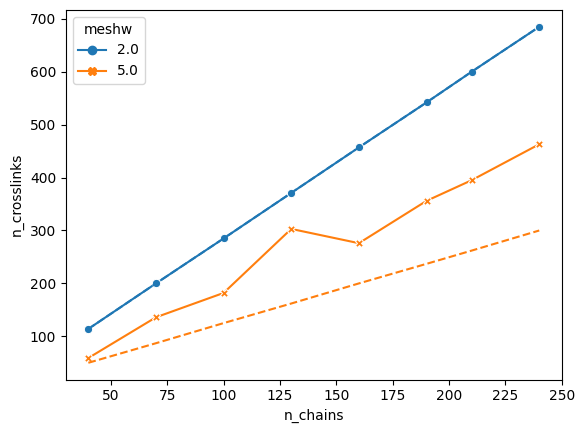

In [159]:
import seaborn as sns
sns.lineplot(df, x="n_chains", y="n_crosslinks", hue="meshw", style="meshw", markers=True, dashes=False)
plt.plot(df[df["meshw"] == 2.0]["n_chains"], df[df["meshw"] == 2.0]["desired_n_crosslinks"], "--", color="C0")
plt.plot(df[df["meshw"] == 5.0]["n_chains"], df[df["meshw"] == 5.0]["desired_n_crosslinks"], "--", color="C1")
plt.show()

ich hätte gerne eine klare positive korrelation von meshw zur median pore size

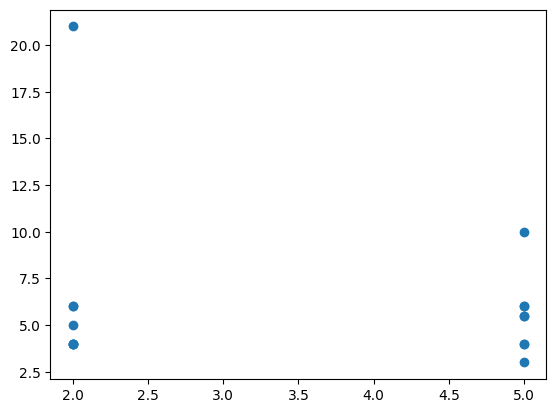

In [160]:
plt.scatter(df["meshw"], df["pore_size_median"])
plt.show()

auch wenn man den outlier bei meshw=2 und median pore size ca 20 raus nimmt, ist die korrelation nicht wirklich gut.

In [161]:
df_exploded = df.explode("beads_per_pore").reset_index(drop=True)

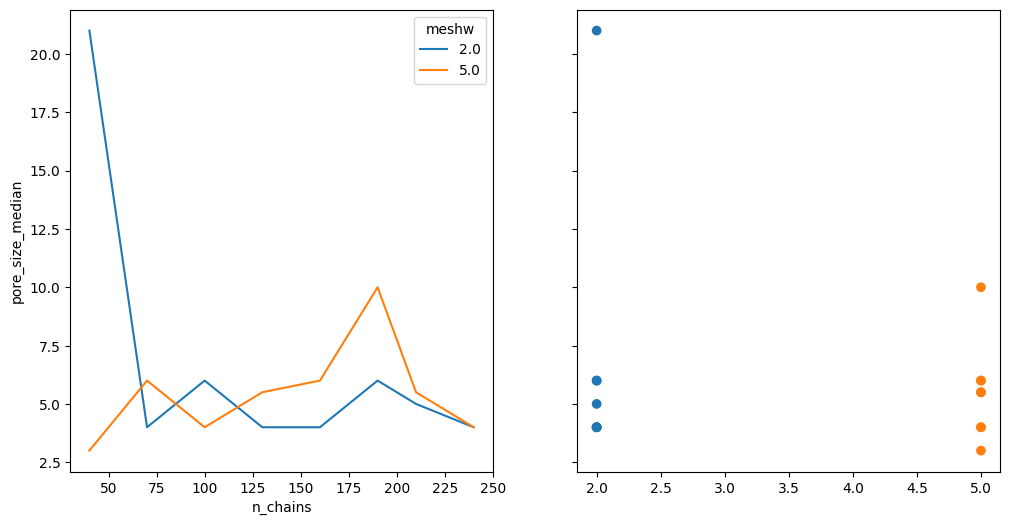

In [162]:
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(12, 6), sharey=True)
sns.lineplot(df, x="n_chains", y="pore_size_median", hue="meshw", ax=ax1)
ax2.scatter(df["meshw"], df["pore_size_median"], c=np.where(df["meshw"]==2.0, "C0", "C1"))
plt.show()

For this I would expect/want that the smaller meshw also has the smaller median pore size. That is its line is always below the other.

And indeed, this is almost true. But also not really statistically significant.

But why do I see it here but not in the korrelation plot? The korrelation plot is basically a projection of this plot onto the y axis. (left side of y for small meshw and right side for large)

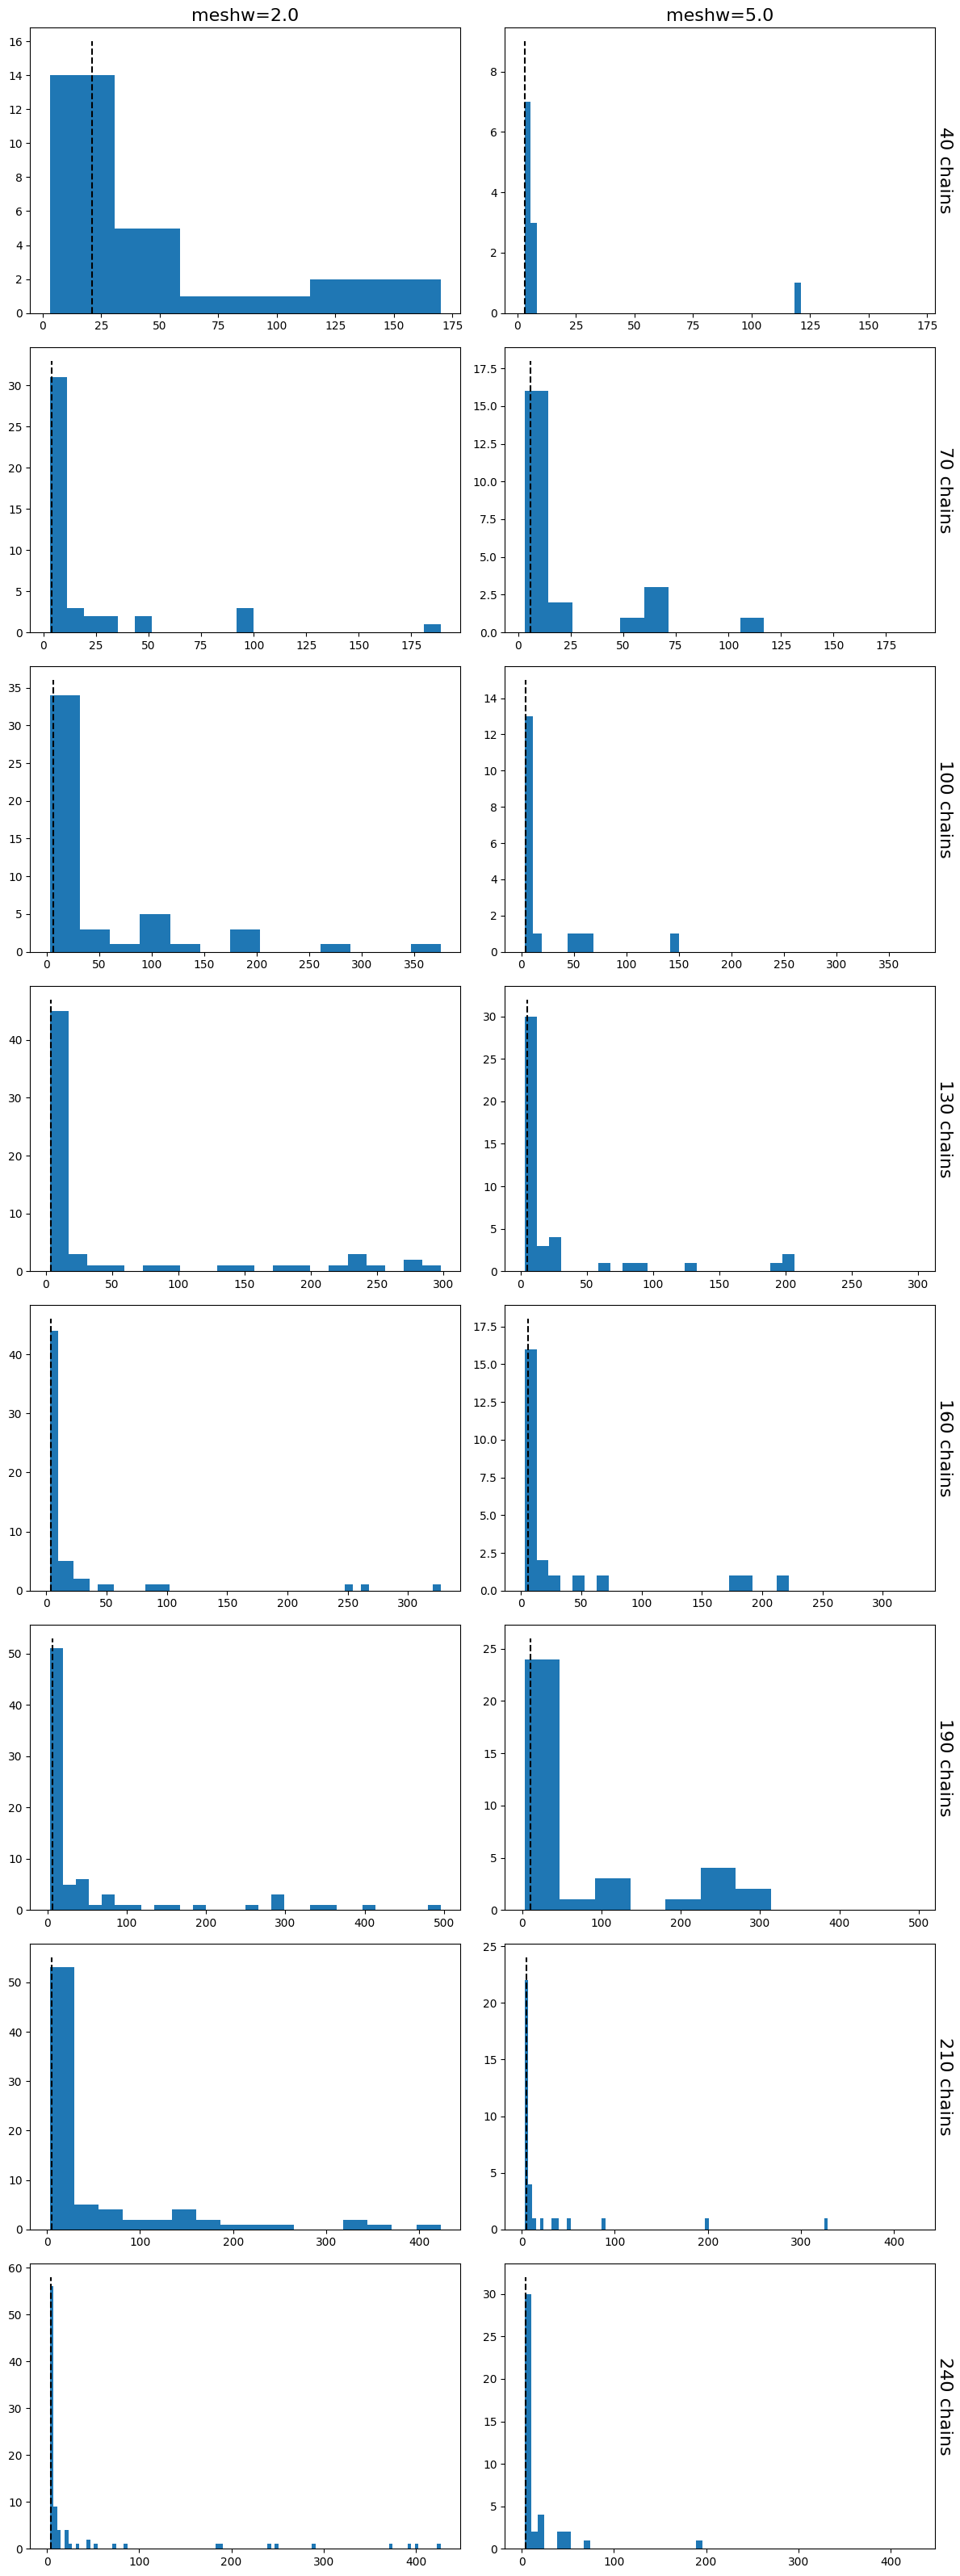

In [163]:
import matplotlib.transforms as transforms

TEXT_SIZE=16

ncols=2
nrows = len(df["n_chains"].unique())
fig, axs = plt.subplots(ncols=ncols, nrows=nrows, figsize=(6*ncols, 4*nrows), sharex="row", sharey=False)
for i, ((n_chains, meshw), sub_df) in enumerate(df_exploded.groupby(["n_chains", "meshw"])):
    row = i // ncols
    col = i % ncols
    ax: plt.Axes = axs[row, col]
    if row == 0:
        ax.set_title(f"{meshw=}", size=TEXT_SIZE)
    if col == ncols-1:
        offset = transforms.ScaledTranslation(0.02, 0, fig.dpi_scale_trans) # Adjust offset as needed
        transform = ax.transAxes + offset  # Combine with axes transform
        ax.text(1.0, 0.5, f"{n_chains} chains", rotation=-90, va="center", transform=transform, size=TEXT_SIZE)

    dens, bins, _ = ax.hist(sub_df["beads_per_pore"], bins="auto")
    ax.vlines([np.median(sub_df["beads_per_pore"])], 0, np.max(dens)+2, colors="black", linestyles="--")
plt.tight_layout()
plt.show()